In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
pip install efficientnet_pytorch

  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16427 sha256=62450190d2f60c4031a744bd3fa40f0d5cb1d68b4106e4a22a00f1d615a21037
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
Successfully built efficientnet_pytorch
Note: you may need to restart the kernel to use updated packages.


In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import models, transforms, datasets
from torch.optim.lr_scheduler import ReduceLROnPlateau
import numpy as np
from efficientnet_pytorch import EfficientNet  # Import EfficientNet
import copy  # For early stopping

# Check if GPU is available and set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define transforms for resizing and normalization
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load datasets
train_dataset = datasets.ImageFolder(root='/kaggle/input/new-cv-dataset-train-val-test/data/train(0,3,4)', transform=transform)
valid_dataset = datasets.ImageFolder(root='/kaggle/input/new-cv-dataset-train-val-test/data/val(0,3,4)', transform=transform)
test_dataset = datasets.ImageFolder(root='/kaggle/input/new-cv-dataset-train-val-test/data/test(0,3,4)', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define the custom cascading model combining EfficientNet, ResNet, and DenseNet
class CascadeModel(nn.Module):
    def __init__(self, num_classes):
        super(CascadeModel, self).__init__()
        self.efficientnet = EfficientNet.from_pretrained('efficientnet-b0')  # Load EfficientNet
        self.resnet = models.resnet50(pretrained=True)  # Load ResNet
        self.densenet = models.densenet121(pretrained=True)  # Load DenseNet
        self.fc = nn.Linear(1000, num_classes)  # Final layer for classification

    def forward(self, x, labels):
        # EfficientNet output
        eff_output = self.efficientnet(x)
        eff_probs = torch.nn.functional.softmax(eff_output, dim=1)
        eff_pred = eff_probs.max(1)[1]
        
        # Use ResNet for incorrect predictions
        incorrect_mask_eff = eff_pred != labels  # Identify incorrect predictions
        if incorrect_mask_eff.any():
            res_output = self.resnet(x[incorrect_mask_eff])
            eff_output[incorrect_mask_eff] = res_output  # Replace incorrect outputs with ResNet predictions
        
        # Use DenseNet for incorrect predictions from ResNet
        incorrect_mask_res = eff_pred != labels  # Re-check incorrect predictions
        if incorrect_mask_res.any():
            dense_output = self.densenet(x[incorrect_mask_res])
            eff_output[incorrect_mask_res] = dense_output  # Replace incorrect outputs with DenseNet predictions
        
        return eff_output

# Training loop with Early Stopping and Weight Decay
def train_model(model, train_loader, valid_loader, criterion, optimizer, num_epochs=10, patience=3):
    best_model_wts = copy.deepcopy(model.state_dict())  # Track best model weights
    best_acc = 0.0
    epoch_no_improve = 0  # Count epochs with no improvement in validation accuracy
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_preds = 0
        total_preds = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs, labels)  # Pass inputs and labels to the model
            
            # Calculate loss based on the final output (after cascade)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_preds += (predicted == labels).sum().item()
            total_preds += labels.size(0)
        
        train_loss = running_loss / len(train_loader)
        train_accuracy = correct_preds / total_preds * 100
        
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.2f}%")
        
        # Validation phase
        model.eval()
        correct_preds = 0
        total_preds = 0
        with torch.no_grad():
            for inputs, labels in valid_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs, labels)  # Use model with inputs and labels
                _, predicted = torch.max(outputs, 1)
                correct_preds += (predicted == labels).sum().item()
                total_preds += labels.size(0)
        
        validation_accuracy = correct_preds / total_preds * 100
        print(f"Validation Accuracy: {validation_accuracy:.2f}%")
        
        # Early stopping check
        if validation_accuracy > best_acc:
            best_acc = validation_accuracy
            best_model_wts = copy.deepcopy(model.state_dict())  # Save best model
            epoch_no_improve = 0  # Reset the no improvement counter
        else:
            epoch_no_improve += 1
            if epoch_no_improve >= patience:
                print("Early stopping...")
                break
    
    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model

# Test the model
def test_model(model, test_loader):
    model.eval()
    correct_preds = 0
    total_preds = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs, labels)  # Use model with inputs and labels
            _, predicted = torch.max(outputs, 1)
            correct_preds += (predicted == labels).sum().item()
            total_preds += labels.size(0)
    
    test_accuracy = correct_preds / total_preds * 100
    print(f"Test Accuracy: {test_accuracy:.2f}%")

# Initialize the model, criterion, and optimizer
num_classes = len(train_dataset.classes)  # Number of classes in the dataset
model = CascadeModel(num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.0001)  # Adding L2 regularization (weight decay)

# Train the model
model = train_model(model, train_loader, valid_loader, criterion, optimizer, num_epochs=10, patience=3)

# Test the model
test_model(model, test_loader)


Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth
100%|██████████| 20.4M/20.4M [00:00<00:00, 134MB/s] 


Loaded pretrained weights for efficientnet-b0
Epoch [1/10], Loss: 1.4952, Accuracy: 70.07%
Validation Accuracy: 65.08%
Epoch [2/10], Loss: 0.5738, Accuracy: 92.80%
Validation Accuracy: 63.34%
Epoch [3/10], Loss: 0.5093, Accuracy: 95.07%
Validation Accuracy: 90.89%
Epoch [4/10], Loss: 0.0444, Accuracy: 99.93%
Validation Accuracy: 91.97%
Epoch [5/10], Loss: 0.0150, Accuracy: 99.93%
Validation Accuracy: 89.80%
Epoch [6/10], Loss: 0.0090, Accuracy: 100.00%
Validation Accuracy: 86.55%
Epoch [7/10], Loss: 0.0079, Accuracy: 99.93%
Validation Accuracy: 85.47%
Early stopping...
Test Accuracy: 92.33%


In [17]:
pip install efficientnet_pytorch

  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16427 sha256=150395c4dad5205d7269083cf7f7a54e875ff0cd1e46f381461189579bc1c076
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
Successfully built efficientnet_pytorch
Note: you may need to restart the kernel to use updated packages.


In [19]:
# Initialize the model
model = CascadingModel().to(device)  # Ensure this matches the architecture used during training

# Load the saved model weights
model.load_state_dict(torch.load(r"/kaggle/working/best_model.pth"))

# Set the model to evaluation mode
model.eval()


/tmp/ipykernel_30/2719540630.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(r"/kaggle/working/best_model.pth"))


CascadingModel(
  (efficientnet): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
              (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (activation): SiLU(inplace=True)
              

The predicted class for the image is: 0
Predicted label index: 0


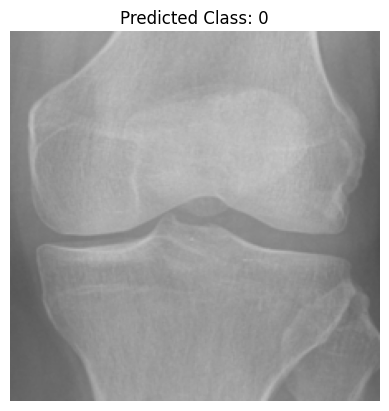

In [28]:
import matplotlib.pyplot as plt
from PIL import Image
import torch

# Load and preprocess the new image
image_path = r"/kaggle/input/new-cv-dataset-train-val-test/data/test(0,3,4)/0/9009927L.png"
image = Image.open(image_path).convert('RGB')  # Convert to RGB if the image is grayscale
image_transformed = transform(image).unsqueeze(0).to(device)  # Add batch dimension and move to device

# Predict the label
with torch.no_grad():
    output = model(image_transformed)
    _, predicted_label = torch.max(output, 1)

# Map the predicted label to original labels [0, 3, 4]
label_map = {0: 0, 1: 3, 2: 4}
predicted_class = label_map[predicted_label.item()]

# Print prediction
print(f"The predicted class for the image is: {predicted_class}")
print(f"Predicted label index: {predicted_label.item()}")

# Display the image
plt.imshow(image)
plt.title(f"Predicted Class: {predicted_class}")
plt.axis('off')  # Hide axes
plt.show()
